In [1]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import math


In [2]:
# Menampilkan Sampel Data Dan Melakukan Drop Column Tertarik
df = pd.read_csv('../Dataset/kendaraan_train_pca_clean.csv')
df_pure = df.copy()
df.sample(5)


,Component_1,Component_2,Tertarik
53793,-0.486944,0.303525,0
220766,0.789426,0.061960,0
249673,-0.973641,0.299916,0
258473,0.597812,-0.523577,1
202966,0.892712,0.167533,0


In [3]:
# Mengecek Data Kosong
df.isna().sum()

Component_1    0
Component_2    0
Tertarik       0
dtype: int64

## **Feature Selection**

In [4]:
df = df[['Component_1', 'Component_2']]
df_pure = df.copy()
df.head()

,Component_1,Component_2
0,-1.104157,-0.227001
1,1.485107,0.669455
2,-0.979955,0.290973
3,0.119497,-0.051135
4,1.410215,0.593691


In [5]:
# Mengecek Total Data Pada Dataframe
print("Total Data :", len(df))

Total Data : 285662


## **K-MEANS Algorithm**

In [6]:
# Mendefinisikan Metode Euclidean Untuk Perhitungan Jarak Dari Centroid
def euclidean(x, y):
    return math.sqrt(sum((x - y)**2))

# Pemberhentian Proses Iterasi Ketika Centroid Saat Ini Sama Dengan Nilai Centroid Sebelumnya
# Dilakukan Dengan Pengecekan Masing-Masing Value Dari Dictionary
def is_convergent(temp_centroid, centroid, k):
    for i in range(k):
        if (temp_centroid.get(i) != centroid.get(i))[0]:
            return False

    return True

def kmeans(k, max_iter, df):
    total_wcss = 0
    # Inisialisasi Dictionary Centroid Kemudian Memilih Centroid Secara Random Pada Data
    # Sesuai Banyaknya Cluster Yang Didefinisikan
    centroid = {i: df[random.randint(0, len(df))] for i in range(k)}
    
    # Mengcopy Centroid Saat Ini Untuk Acuan Pemberhentian Proses Iterasi Centroid Maksimal
    temp_centroid = centroid.copy()
    
    for _ in range(max_iter):
        # Mendefinisikan Dictionary Cluster Dan Mengisi Setiap Key
        # Pada Cluster Berisi Array kosong, contoh : {0: [], 1: [], 2: []}
        cluster = {i: [] for i in range(k)}
        wcss = []

        # Mencari Nilai Terdekat Pada Data Untuk Setiap Centroid Yang Telah Di Definisikan Sebelumnya
        # Menggunakan Metode Euclidean Dan Mencari Nilai Minimum Pada Setiap Distance
        # Untuk Dimasukkan Kedalam Dictionary Cluster
        for x in df:
            dist = [euclidean(x, centroid[c]) for c in centroid]
            wcss.append(np.min(dist))
            cluster[dist.index(min(dist))].append(x)
            
        # Mencari Nilai Centroid Ulang Dari Setiap Cluster
        # Yang Telah Dicari Sebelumnya Menggunakan Mean
        for cl in cluster:
            centroid[cl] = np.mean(cluster[cl], axis=0)
            
        # Mengecek Jika Centroid Telah Mencapai Nilai Maksimum / Konvergen
        if is_convergent(temp_centroid, centroid, k): break

        # Mengcopy Centroid Yang Telah Berubah Dari Perhitungan Sebelumnya
        temp_centroid = centroid.copy()

    # Mengembalikan Nilai Dari Variabel Centroid Dan Cluster
    return centroid, cluster, sum(wcss)


## **Evaluasi Model**

In [7]:
def make_cluster(cluster):
    # Inisialisasi Array Untuk Data Cluster
    df = []

    # Melakukan Perulangan Untuk Setiap Key Pada Data
    # Hasil Proses K-Means Untuk Diinputkan Kedalam Array Cluster (df)
    for key in cluster[1].keys():
        for c in cluster[1].get(key):
            df.append((c[0], c[1], key))

    # Set Array df menjadi dataframe, Menamakan nama kolom dan menampilkannya
    df = pd.DataFrame(df)
    df.columns = ['Umur', 'Kanal_Penjualan', 'Cluster']
    
    return df

In [14]:
def visualize_cluster(cluster_all):
    # Set Array Untuk Hasil Klasterisasi 
    clusterize = []

    # Subplot Untuk Plot Chart Beserta Inisialisasi Nilai Baris Dan Kolomnya
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    row = 0
    col = 0
   
    for cluster in cluster_all: 
        # Membuat Dataframe Untuk Setiap Cluster Dan Memasukkan Jenis Clusternya Untuk Menghitung Score
        df = make_cluster(cluster)
        clusterize.append(df)

        # Set Warna Setiap Cluster
        colors = ['r', 'g', '#0080ff', '#e69500', '#bd17ff']

        # Set Title Untuk Setiap Plottingan Cluster
        axs[col, row].set_title(f'Model Dengan {cluster[0]} Cluster', fontsize=14)

        # Melakukan Looping Setiap Titik Data Dan Centroid
        for i in range(cluster[0]):
            axs[col][row].scatter(
                df['Umur'][df['Cluster'] == i],
                df['Kanal_Penjualan'][df['Cluster'] == i],
                color=colors[i],
                label=f'Cluster {i}'
            )

            axs[col][row].scatter(cluster[2][i][0], cluster[2][i][1], color='k', marker='P')

        # Acuan Penampilan Legend Centroid
        axs[col][row].scatter(cluster[2][0][0], cluster[2][0][1], color='k', label="Centroids", marker='P')
                            
        # Set Nama Label X Dan Y Pada Plot Dan Set Tempat Legend Ditampilkan
        axs[col][row].legend(loc='best', bbox_to_anchor=(1, 0.5))

        # Mengatur Row Dan Column Untuk Array Axis Yang Akan Ditampilkan 
        row += 1
        if row == 2: row = 0
        if row == 0 and col == 0: 
            row = 0
            col = 1 

    # Set Label Untuk Axis x Dan y 
    for ax in axs.flat:
        ax.set(xlabel='Umur', ylabel='Kanal Penjualan')
        ax.label_outer()

    # Mengatur Padding Dan Menampilkan Plot
    plt.subplots_adjust(wspace=0.3, hspace=0.1)
    plt.show()

    return clusterize

## **Main Program**

In [9]:
# Inisialisasi Array Untuk WCSS Dan Keseluruhan Hasil Cluster
wcss_all = []
cluster_all = [] 

# Merubah DataFrame Menjadi Numpy Array
data = df.to_numpy()

# Memasukkan Nilai Maksimum Iterasi
max_iter = 100

# Inisialisasi Range K
K = range(2, 6)

# Melakukan Perulangan Untuk Setiap Range
for i in K:

    # Menggunakan Model Yang Telah Dibangun Untuk Mendapatkan Centroid, Cluster Dan Nilai WCSS 
    centroid, cluster, wcss = kmeans(i, max_iter, data)
    print(f'Centroid Cluster-{i}: \n{centroid}\n')
    
    # Memasukkan Setiap Nilai Yang Direturn Kedalam Array
    wcss_all.append(wcss)
    cluster_all.append([i, cluster, centroid])    


Centroid Cluster-2: 
{0: array([ 0.5927976 , -0.16620815]), 1: array([-0.71950671,  0.20173476])}

Centroid Cluster-3: 
{0: array([ 0.10188521, -0.670874  ]), 1: array([0.79433957, 0.10603881]), 2: array([-0.72989197,  0.26907317])}

Centroid Cluster-4: 
{0: array([-0.58594619, -0.66590328]), 1: array([-0.72989197,  0.26907317]), 2: array([ 0.25320537, -0.6523898 ]), 3: array([0.79959387, 0.12989547])}

Centroid Cluster-5: 
{0: array([ 0.64631027, -0.46267425]), 1: array([0.58454384, 0.1293803 ]), 2: array([1.06035045, 0.26523849]), 3: array([-0.72989197,  0.26907317]), 4: array([-0.11854097, -0.77785611])}



## **Visualisasi Model Setiap Cluster**

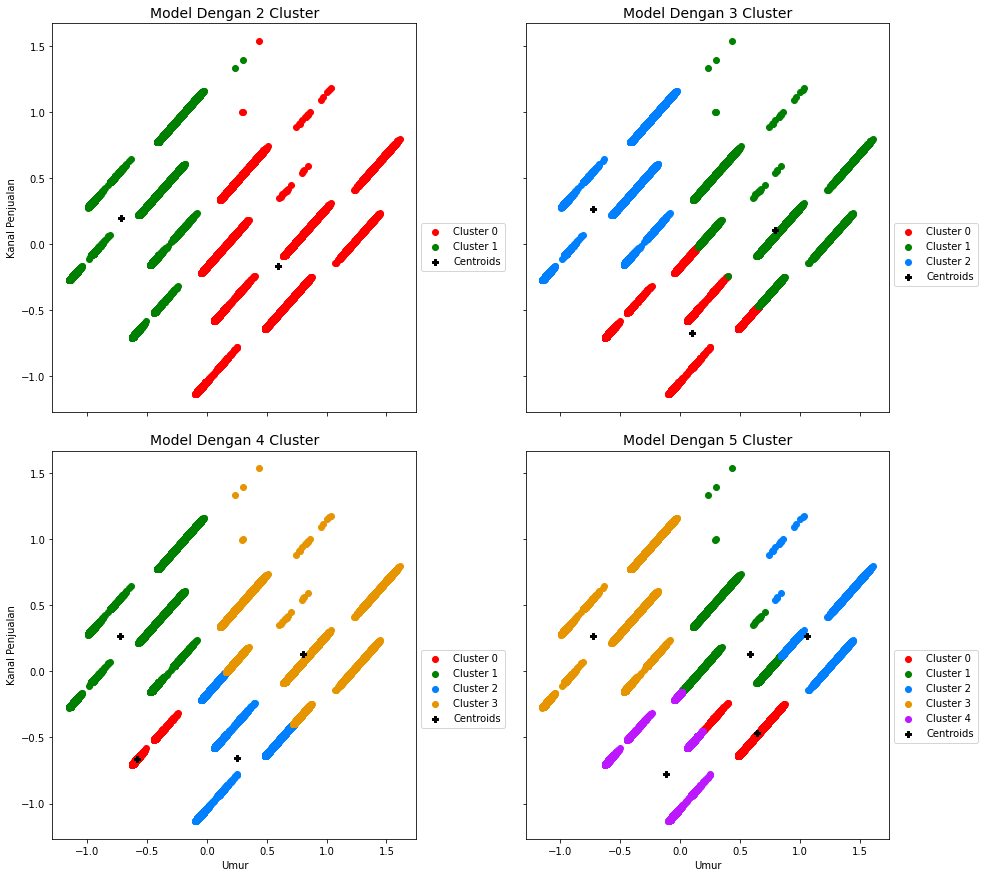

In [15]:
clusterize = visualize_cluster(cluster_all)

## **Evaluasi Model Cluster**

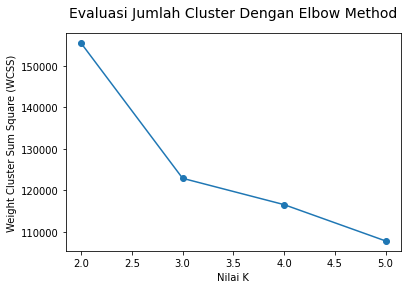

In [11]:
# Plot data
plt.plot(K, wcss_all, marker='o')
plt.xlabel('Nilai K')
plt.ylabel('Weight Cluster Sum Square (WCSS)')
plt.title('Evaluasi Jumlah Cluster Dengan Elbow Method', fontsize=14, pad=16)
plt.show()

In [20]:
for i, cluster in enumerate(clusterize):
    score = silhouette_score(cluster[['Umur', 'Kanal_Penjualan']], cluster['Cluster'])
    print(f'Cluster-{i+2}, Silhouette Score = {score}')


Cluster-2, Silhouette Score = 0.5206031182046656
Cluster-3, Silhouette Score = 0.4913909319585213
Cluster-4, Silhouette Score = 0.3839338250023323
Cluster-5, Silhouette Score = 0.44146386756909606
